In [ ]:
# imports of libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
# !pip install geopandas
import os
from google.colab import drive
drive.mount('/content/drive')
# !pip install folium pandas geopy
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim



In [ ]:
# load data
leases_data = pd.read_csv("/content/drive/Shareddrives/DataFest 2025/2. Data/Leases.csv")
market_occupancy_data = pd.read_csv("/content/drive/Shareddrives/DataFest 2025/2. Data/Major Market Occupancy Data.csv")


# make sure data loaded fine
# Check basic structure
leases_data.info()  # Data types, missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194685 entries, 0 to 194684
Data columns (total 35 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   year                            194685 non-null  int64  
 1   quarter                         194685 non-null  object 
 2   monthsigned                     193822 non-null  float64
 3   market                          194685 non-null  object 
 4   building_name                   157999 non-null  object 
 5   building_id                     194685 non-null  object 
 6   address                         194685 non-null  object 
 7   region                          194685 non-null  object 
 8   city                            194685 non-null  object 
 9   state                           194685 non-null  object 
 10  zip                             194684 non-null  float64
 11  internal_submarket              194685 non-null  object 
 12  internal_class  

# **Initial Visualization**

In [ ]:
leases_data.head()  # Preview first few rows

,year,quarter,monthsigned,market,building_name,building_id,address,region,city,state,...,overall_rent,direct_available_space,direct_availability_proportion,direct_internal_class_rent,direct_overall_rent,sublet_available_space,sublet_availability_proportion,sublet_internal_class_rent,sublet_overall_rent,leasing
0,2018,Q1,1.0,Atlanta,10 Glenlake North Tower,Atlanta_Central Perimeter_Atlanta_10 Glenlake ...,10 Glenlake Pky NE,South,Atlanta,GA,...,24.345689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1205126.0
1,2018,Q1,1.0,Atlanta,100 City View,Atlanta_Northwest_Atlanta_100 City View_3330 C...,3330 Cumberland Blvd,South,Atlanta,GA,...,24.345689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1205126.0
2,2018,Q1,1.0,Atlanta,1000 Parkwood,Atlanta_Northwest_Atlanta_1000 Parkwood_1000 P...,1000 Parkwood Cir SE,South,Atlanta,GA,...,24.345689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1205126.0
3,2018,Q1,1.0,Atlanta,1100 Circle 75,Atlanta_Northwest_Atlanta_1100 Circle 75_1100 ...,1100 Circle 75 Pky SE,South,Atlanta,GA,...,24.345689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,715742.0
4,2018,Q1,1.0,Atlanta,1200 Ashwood,Atlanta_Central Perimeter_Atlanta_1200 Ashwood...,1200 Ashwood Pky,South,Atlanta,GA,...,24.345689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1205126.0


In [ ]:
'''
Key questions:
- What are the most active leasing markets (cities/states)?
- What types of companies are leasing the most office space?
- How has leasing activity changed over time (before & after COVID-19)?
- Which submarkets (e.g., Midtown, Downtown) have the most transactions?
- Are some sectors (Finance, Tech, Legal) leasing more space than others?

'''

'\nKey questions:\n- What are the most active leasing markets (cities/states)?\n- What types of companies are leasing the most office space?\n- How has leasing activity changed over time (before & after COVID-19)?\n- Which submarkets (e.g., Midtown, Downtown) have the most transactions?\n- Are some sectors (Finance, Tech, Legal) leasing more space than others?\n\n'

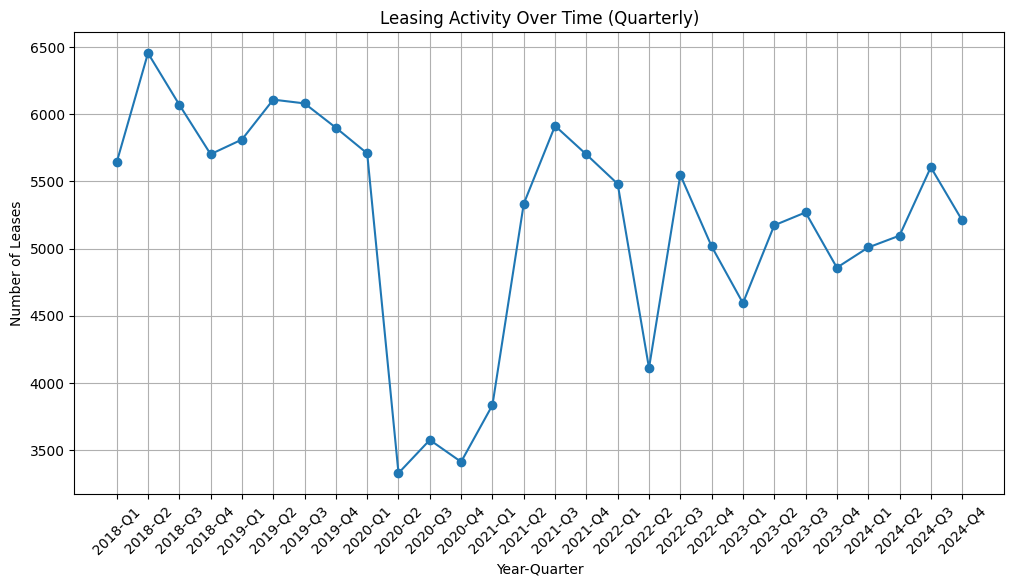

In [ ]:
# Leasing activity over time
## Number of leases per year
# Group by year and quarter, counting the number of leases
leases_per_quarter = leases_data.groupby(["year", "quarter"])["leasing"].count().reset_index()

# Create a new column that combines year and quarter (e.g., "2018-Q1", "2018-Q2", etc.)
leases_per_quarter["year_quarter"] = leases_per_quarter["year"].astype(str) + "-" + leases_per_quarter["quarter"]

# Plot the leasing activity over time (by quarter)
plt.figure(figsize=(12,6))
plt.plot(leases_per_quarter["year_quarter"], leases_per_quarter["leasing"], marker="o", linestyle="-")

plt.xlabel("Year-Quarter")
plt.ylabel("Number of Leases")
plt.title("Leasing Activity Over Time (Quarterly)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid()
plt.show()

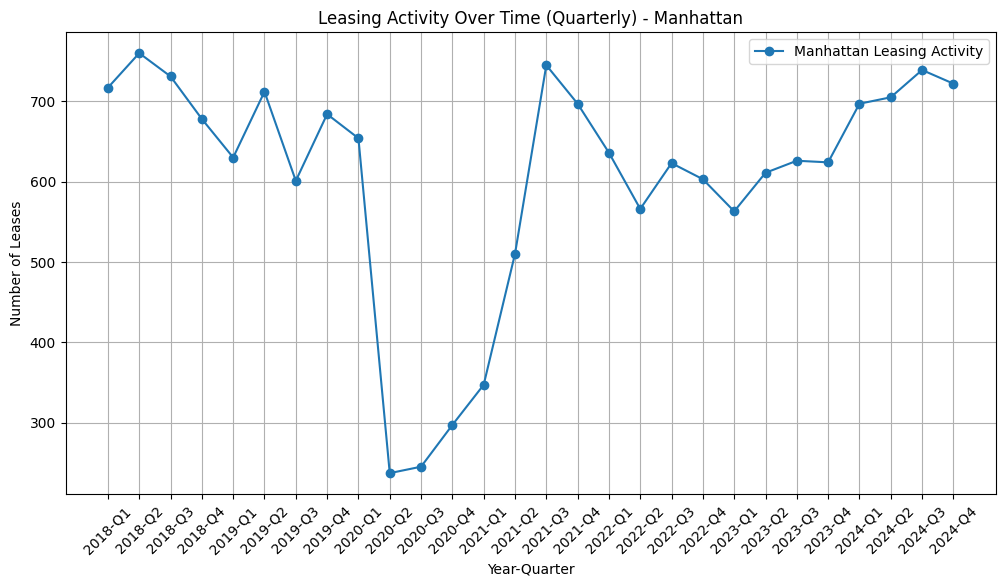

In [ ]:

# Step 1: Filter for Manhattan leases
manhattan_leases = leases_data[leases_data["market"] == "Manhattan"]

# Step 2: Group by year and quarter, counting the number of leases
manhattan_leases_per_quarter = manhattan_leases.groupby(["year", "quarter"])["leasing"].count().reset_index()

# Step 3: Create a new column that combines year and quarter (e.g., "2018-Q1", "2018-Q2", etc.)
manhattan_leases_per_quarter["year_quarter"] = (
    manhattan_leases_per_quarter["year"].astype(str) + "-" + manhattan_leases_per_quarter["quarter"]
)

# Step 4: Plot the leasing activity over time (for Manhattan)
plt.figure(figsize=(12,6))
plt.plot(manhattan_leases_per_quarter["year_quarter"], manhattan_leases_per_quarter["leasing"],
         marker="o", linestyle="-", label="Manhattan Leasing Activity")

plt.xlabel("Year-Quarter")
plt.ylabel("Number of Leases")
plt.title("Leasing Activity Over Time (Quarterly) - Manhattan")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid()
plt.legend()
plt.show()


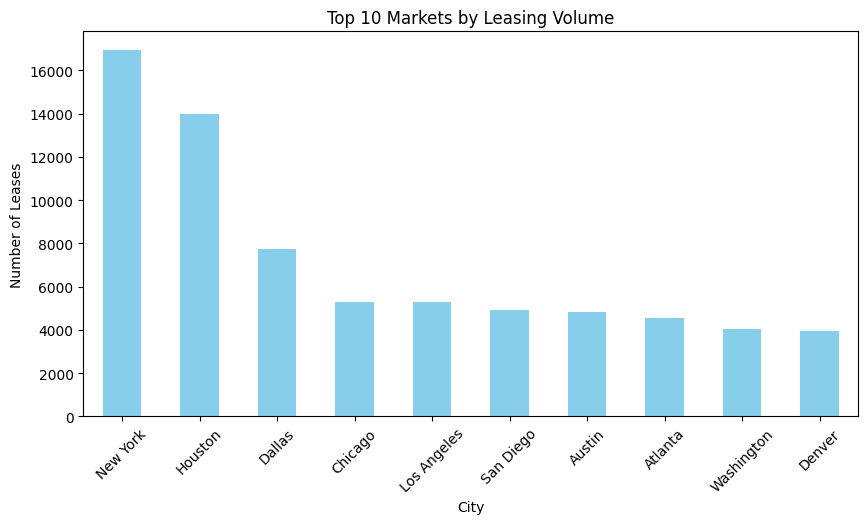

In [ ]:
# Cities by leasing volume

leases_per_city = leases_data["city"].value_counts().head(10)

plt.figure(figsize=(10,5))
leases_per_city.plot(kind="bar", color="skyblue")
plt.xlabel("City")
plt.ylabel("Number of Leases")
plt.title("Top 10 Markets by Leasing Volume")
plt.xticks(rotation=45)
plt.show()


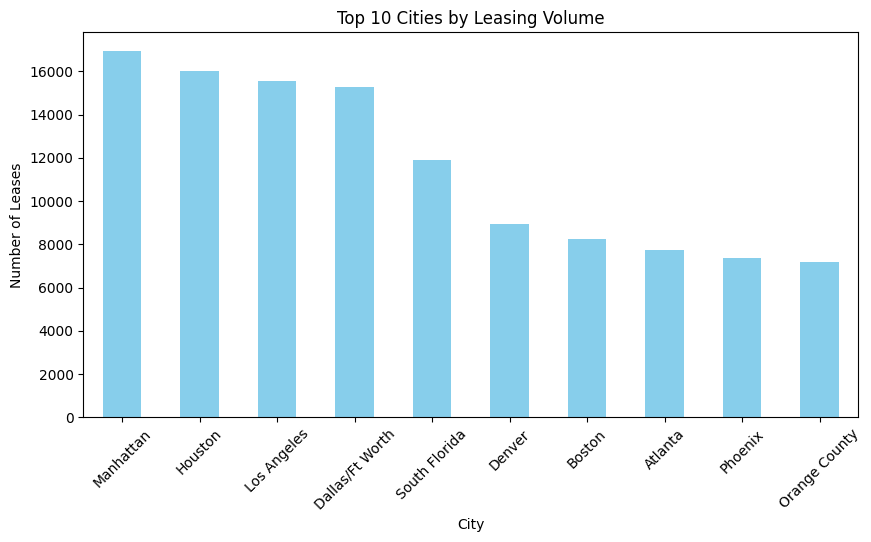

In [ ]:
# Markets by leasing volume

leases_per_city = leases_data["market"].value_counts().head(10)

plt.figure(figsize=(10,5))
leases_per_city.plot(kind="bar", color="skyblue")
plt.xlabel("City")
plt.ylabel("Number of Leases")
plt.title("Top 10 Cities by Leasing Volume")
plt.xticks(rotation=45)
plt.show()


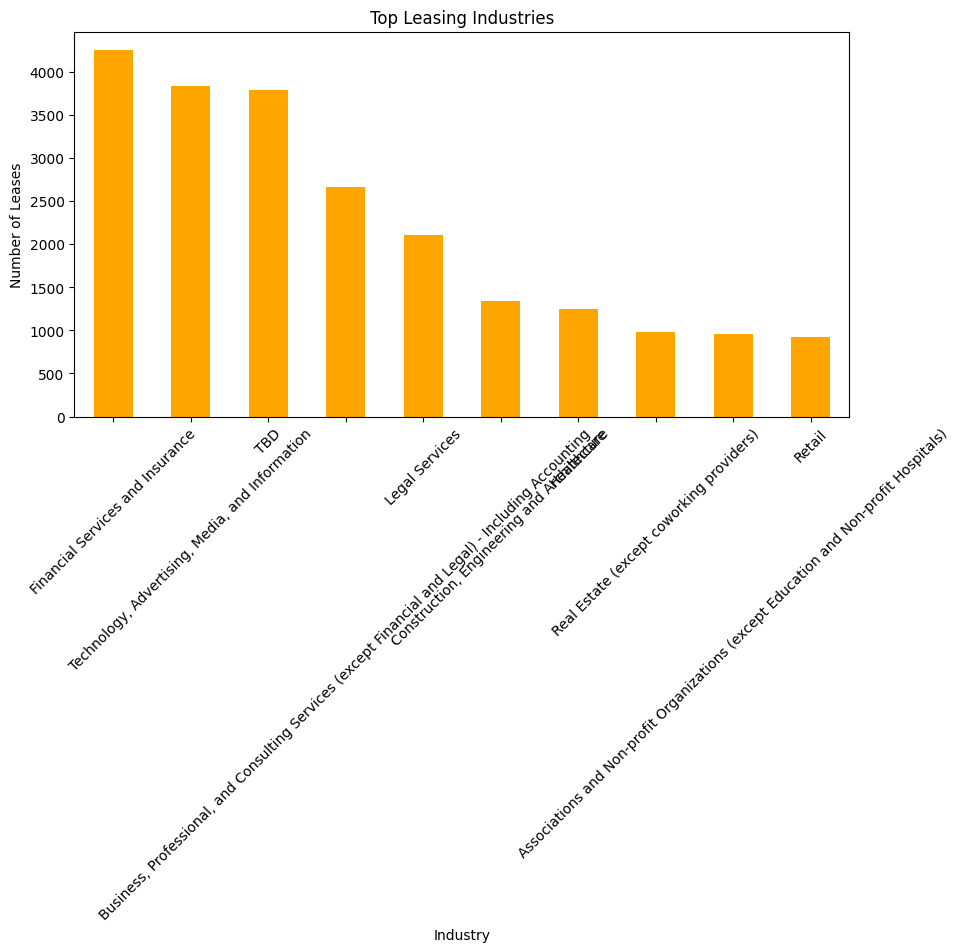

In [ ]:
# Leasting by sector
leases_per_industry = leases_data["internal_industry"].value_counts().head(10)

plt.figure(figsize=(10,5))
leases_per_industry.plot(kind="bar", color="orange")
plt.xlabel("Industry")
plt.ylabel("Number of Leases")
plt.title("Top Leasing Industries")
plt.xticks(rotation=45)
plt.show()


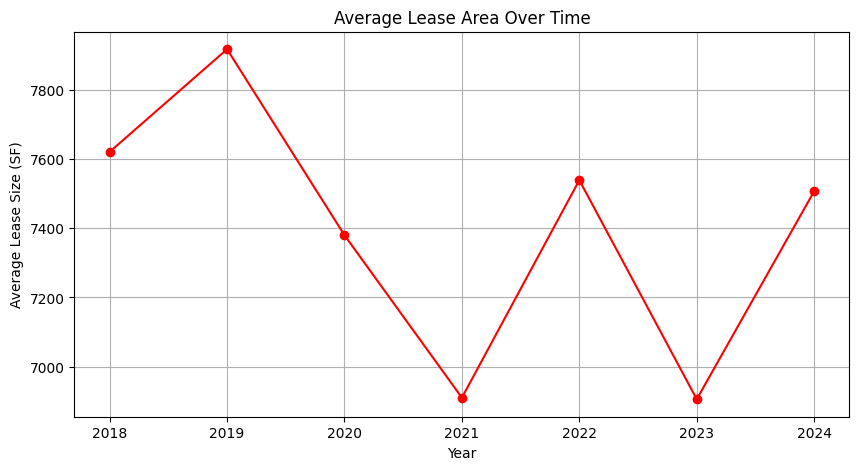

In [ ]:
# Lease size per year

leases_size_per_year = leases_data.groupby("year")["leasedSF"].mean()

plt.figure(figsize=(10,5))
plt.plot(leases_size_per_year.index, leases_size_per_year.values, marker="o", linestyle="-", color="red")
plt.xlabel("Year")
plt.ylabel("Average Lease Size (SF)")
plt.title("Average Lease Area Over Time")
plt.grid()
plt.show()


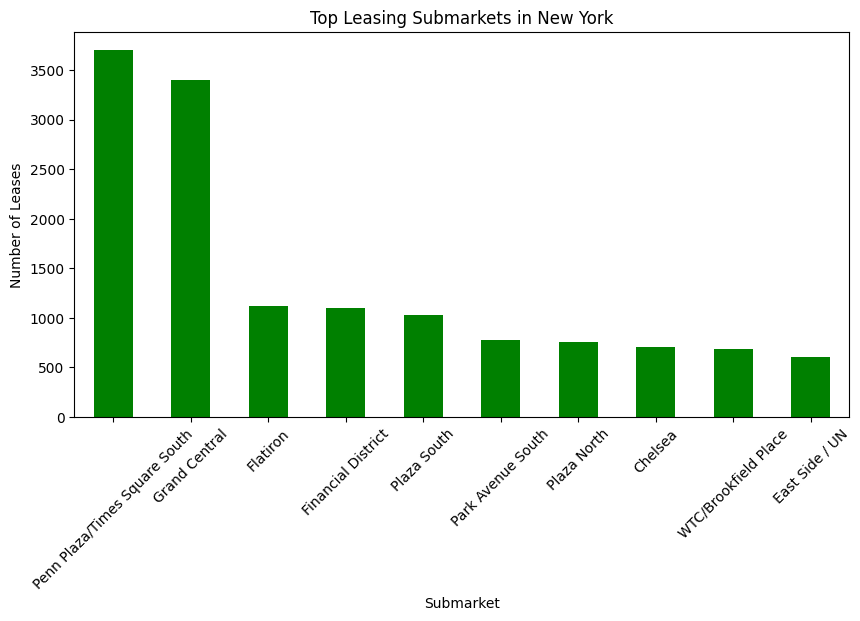

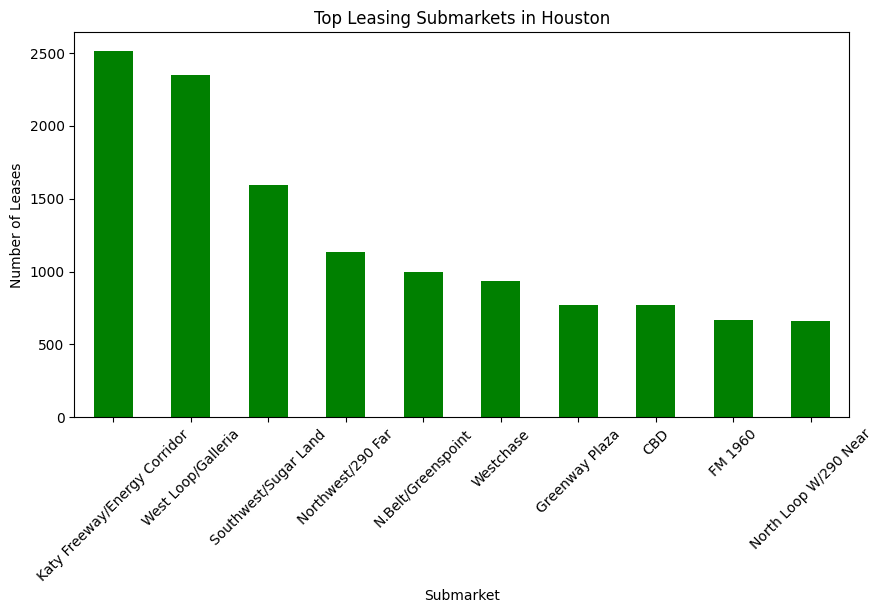

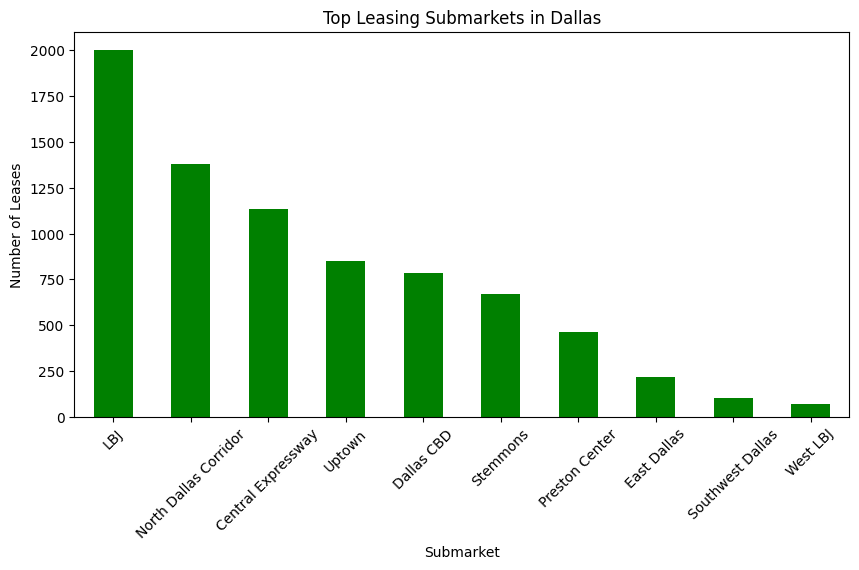

In [ ]:
# Submarket leasing by city based on areas by leasing volume

# New York
city_to_analyze = "New York"  # Change to a different city if needed
leases_per_submarket = leases_data[leases_data["city"] == city_to_analyze]["internal_submarket"].value_counts().head(10)

plt.figure(figsize=(10,5))
leases_per_submarket.plot(kind="bar", color="green")
plt.xlabel("Submarket")
plt.ylabel("Number of Leases")
plt.title(f"Top Leasing Submarkets in {city_to_analyze}")
plt.xticks(rotation=45)
plt.show()

# Houston
city_to_analyze = "Houston"  # Change to a different city if needed
leases_per_submarket = leases_data[leases_data["city"] == city_to_analyze]["internal_submarket"].value_counts().head(10)

plt.figure(figsize=(10,5))
leases_per_submarket.plot(kind="bar", color="green")
plt.xlabel("Submarket")
plt.ylabel("Number of Leases")
plt.title(f"Top Leasing Submarkets in {city_to_analyze}")
plt.xticks(rotation=45)
plt.show()


# Dallas
city_to_analyze = "Dallas"  # Change to a different city if needed
leases_per_submarket = leases_data[leases_data["city"] == city_to_analyze]["internal_submarket"].value_counts().head(10)

plt.figure(figsize=(10,5))
leases_per_submarket.plot(kind="bar", color="green")
plt.xlabel("Submarket")
plt.ylabel("Number of Leases")
plt.title(f"Top Leasing Submarkets in {city_to_analyze}")
plt.xticks(rotation=45)
plt.show()




In [ ]:
# Filter Leases.csv (leases_data) by
# Step 1: Ensure we have the list of major markets from the Major Market Occupancy dataset
major_markets = market_occupancy_data['market'].dropna().unique()

# Step 2: Filter leases_data based on the given conditions
filtered_leases = leases_data[
    (leases_data["leasedSF"] >= 10000) &  # Leases must be ≥ 10,000 sqft
    (leases_data["company_name"].notna()) &  # Company name must not be NA
    (leases_data["market"].isin(major_markets))  # Market must be in Major Market Occupancy dataset
]

# Display filtered dataset info
# filtered_leases.info()

# Preview first few rows
filtered_leases.head()

print(major_markets)


['Washington D.C.' 'Manhattan' 'Chicago' 'Houston' 'Philadelphia'
 'San Francisco' 'Los Angeles' 'Dallas/Ft Worth' 'South Bay/San Jose'
 'Austin']


       year quarter  monthsigned     market     building_name  \
16861  2020      Q1          1.0  Manhattan    100112 28th St   
16864  2020      Q1          1.0  Manhattan  101 Greenwich St   
16877  2020      Q1          1.0  Manhattan    111123 38th St   
16880  2020      Q1          1.0  Manhattan     119 W 40th St   
16889  2020      Q1          1.0  Manhattan     1411 Broadway   

                                             building_id           address  \
16861  Manhattan_Park Avenue South_New York_100112 28...    401 Park Ave S   
16864  Manhattan_WTC/Brookfield Place_New York_101 Gr...  101 Greenwich St   
16877  Manhattan_Penn Plaza/Times Square South_New Yo...     1400 Broadway   
16880  Manhattan_Penn Plaza/Times Square South_New Yo...     114 W 41st St   
16889  Manhattan_Penn Plaza/Times Square South_New Yo...     1411 Broadway   

          region      city state  ...  overall_rent direct_available_space  \
16861  Northeast  New York    NY  ...     83.884755           

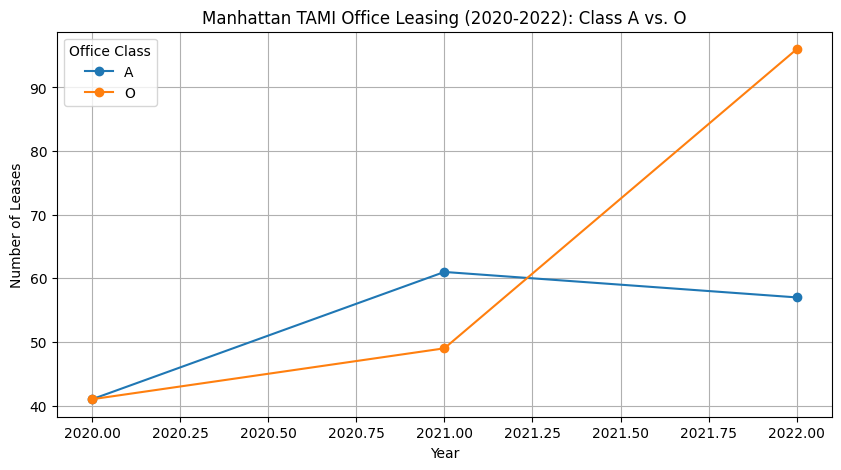

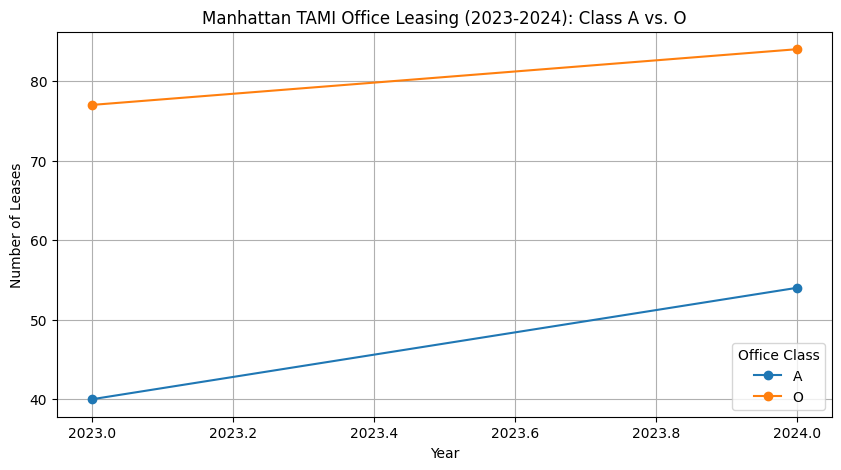

transaction_type  New  Relocation
internal_class                   
A                 109         146
O                 170         171


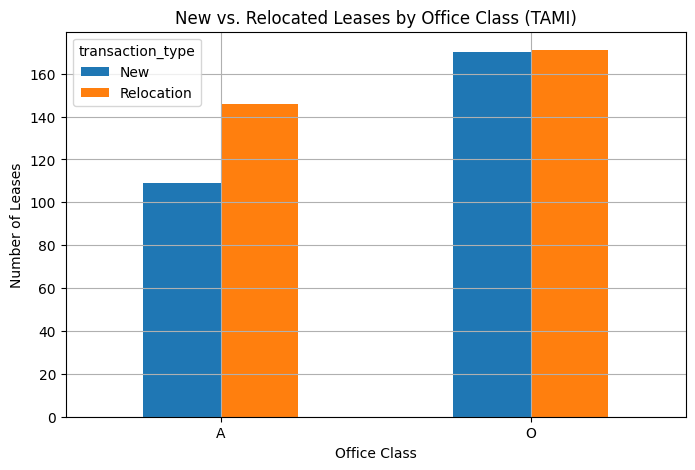

In [ ]:
# Filter for Manhattan leases
manhattan_leases = leases_data[leases_data["market"] == "Manhattan"]

# Filter for Technology, Advertising, Media, and Information industry
tami_filter = manhattan_leases["internal_industry"].str.contains("Technology, Advertising, Media, and Information", na=False)
manhattan_tami_leases = manhattan_leases[tami_filter]

# Separate into 2020-2022 and 2023-2024 datasets
leases_tami_2020_2022 = manhattan_tami_leases[manhattan_tami_leases["year"].isin([2020, 2021, 2022])]
leases_tami_2023_2024 = manhattan_tami_leases[manhattan_tami_leases["year"].isin([2023, 2024])]

# Check data
print(leases_tami_2020_2022.head())
print(leases_tami_2023_2024.head())

# Count leases per class per year
tami_leases_by_class_2020_2022 = leases_tami_2020_2022.groupby(["year", "internal_class"])["leasing"].count().unstack()
tami_leases_by_class_2023_2024 = leases_tami_2023_2024.groupby(["year", "internal_class"])["leasing"].count().unstack()

# Print summary
print(tami_leases_by_class_2020_2022)
print(tami_leases_by_class_2023_2024)

import matplotlib.pyplot as plt

# Plot trends for 2020-2022
plt.figure(figsize=(10, 5))
tami_leases_by_class_2020_2022.plot(kind="line", marker="o", ax=plt.gca())
plt.title("Manhattan TAMI Office Leasing (2020-2022): Class A vs. O")
plt.xlabel("Year")
plt.ylabel("Number of Leases")
plt.legend(title="Office Class")
plt.grid()
plt.show()

# Plot trends for 2023-2024
plt.figure(figsize=(10, 5))
tami_leases_by_class_2023_2024.plot(kind="line", marker="o", ax=plt.gca())
plt.title("Manhattan TAMI Office Leasing (2023-2024): Class A vs. O")
plt.xlabel("Year")
plt.ylabel("Number of Leases")
plt.legend(title="Office Class")
plt.grid()
plt.show()

# Filter for New & Relocation transactions
man_new_rel_tami = manhattan_tami_leases[manhattan_tami_leases["transaction_type"].isin(["New", "Relocation"])]

# Group by class
new_vs_relocate_by_class_tami = man_new_rel_tami.groupby(["internal_class", "transaction_type"])["leasing"].count().unstack()
print(new_vs_relocate_by_class_tami)

# Plot
new_vs_relocate_by_class_tami.plot(kind="bar", figsize=(8,5))
plt.title("New vs. Relocated Leases by Office Class (TAMI)")
plt.ylabel("Number of Leases")
plt.xlabel("Office Class")
plt.xticks(rotation=0)
plt.grid()
plt.show()



Descriptive Summary: Class A vs. Class O Leases (2020-2024) in Manhattan (TAMI)

internal_class  Class A (count)  Class O (count)
year                                            
2020                         41               41
2021                         61               49
2022                         57               96
2023                         40               77
2024                         54               84


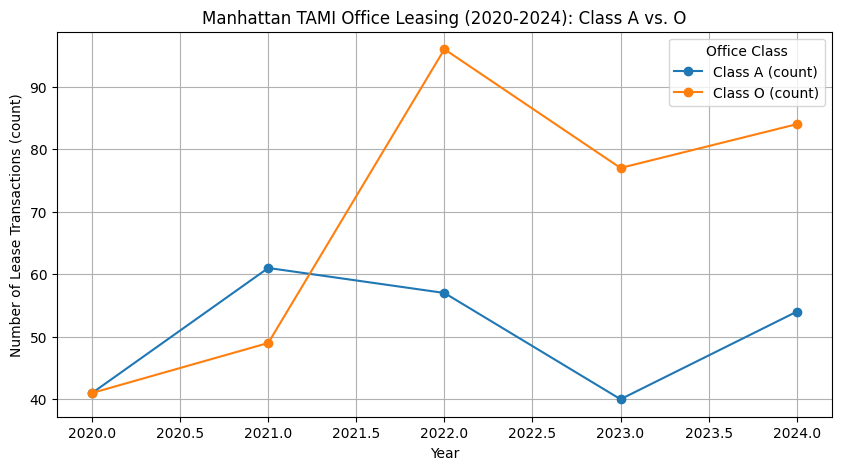


New vs. Relocated Leases by Office Class (TAMI):
 transaction_type  New  Relocation
internal_class                   
A                 109         146
O                 170         171


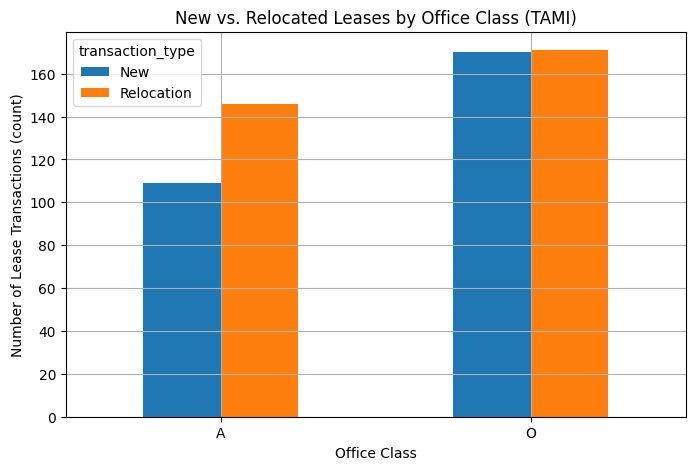

In [15]:
# Filter for Manhattan leases
manhattan_leases = leases_data[leases_data["market"] == "Manhattan"]

# Filter for Technology, Advertising, Media, and Information (TAMI) industry
tami_filter = manhattan_leases["internal_industry"].str.contains(
    "Technology, Advertising, Media, and Information", na=False
)
manhattan_tami_leases = manhattan_leases[tami_filter]

# Filter for years 2020 through 2024
manhattan_tami_2020_2024 = manhattan_tami_leases[
    manhattan_tami_leases["year"].between(2020, 2024)
]

# Group by year and internal_class to count the number of leases
tami_leases_by_class_2020_2024 = (
    manhattan_tami_2020_2024
    .groupby(["year", "internal_class"])["leasing"]
    .count()
    .unstack()
)

# Rename columns to be more descriptive (if columns are just 'A' and 'O')
if 'A' in tami_leases_by_class_2020_2024.columns:
    tami_leases_by_class_2020_2024.rename(columns={'A': 'Class A (count)'}, inplace=True)
if 'O' in tami_leases_by_class_2020_2024.columns:
    tami_leases_by_class_2020_2024.rename(columns={'O': 'Class O (count)'}, inplace=True)

print("Descriptive Summary: Class A vs. Class O Leases (2020-2024) in Manhattan (TAMI)\n")
print(tami_leases_by_class_2020_2024)

# Plot a single line graph from 2020-2024 for Class A vs. O
plt.figure(figsize=(10, 5))
tami_leases_by_class_2020_2024.plot(kind="line", marker="o", ax=plt.gca())

plt.title("Manhattan TAMI Office Leasing (2020-2024): Class A vs. O")
plt.xlabel("Year")
# The y-axis describes the number of leases (count of lease transactions)
plt.ylabel("Number of Lease Transactions (count)")
plt.legend(title="Office Class")
plt.grid(True)
plt.show()

# (Optional) Additional exploration:
# For example, transactions designated as New or Relocation
man_new_rel_tami = manhattan_tami_leases[
    manhattan_tami_leases["transaction_type"].isin(["New", "Relocation"])
]

new_vs_relocate_by_class_tami = man_new_rel_tami.groupby(
    ["internal_class", "transaction_type"]
)["leasing"].count().unstack()

print("\nNew vs. Relocated Leases by Office Class (TAMI):\n", new_vs_relocate_by_class_tami)

new_vs_relocate_by_class_tami.plot(kind="bar", figsize=(8,5))
plt.title("New vs. Relocated Leases by Office Class (TAMI)")
plt.ylabel("Number of Lease Transactions (count)")
plt.xlabel("Office Class")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

Descriptive Summary: Class A vs. Class O Leases (2020-2024) in Manhattan (TAMI)

internal_class  Class A (count)  Class O (count)
year                                            
2020                         41               41
2021                         61               49
2022                         57               96
2023                         40               77
2024                         54               84


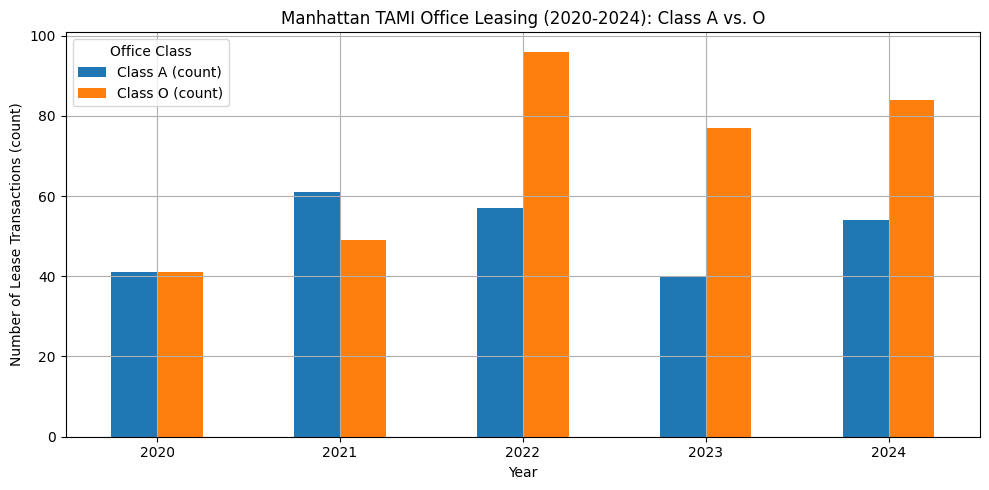


New vs. Relocated Leases by Office Class (TAMI):
 transaction_type  New  Relocation
internal_class                   
A                 109         146
O                 170         171


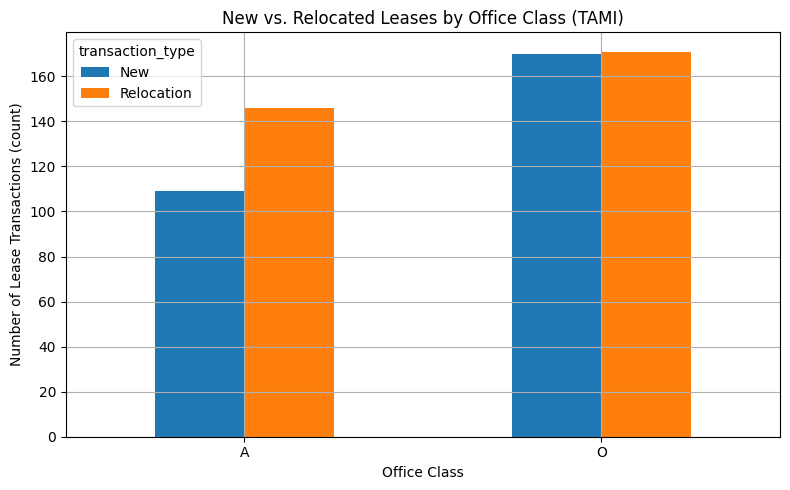

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data (adjust file paths as needed)
# leases_data = pd.read_csv("/content/drive/Shareddrives/DataFest 2025/2. Data/Leases.csv")

# Filter for Manhattan leases
manhattan_leases = leases_data[leases_data["market"] == "Manhattan"]

# Filter for Technology, Advertising, Media, and Information (TAMI) industry
tami_filter = manhattan_leases["internal_industry"].str.contains(
    "Technology, Advertising, Media, and Information", na=False
)
manhattan_tami_leases = manhattan_leases[tami_filter]

# Filter for years 2020 through 2024
manhattan_tami_2020_2024 = manhattan_tami_leases[
    manhattan_tami_leases["year"].between(2020, 2024)
]

# Group by year and internal_class to count the number of leases
tami_leases_by_class_2020_2024 = (
    manhattan_tami_2020_2024
    .groupby(["year", "internal_class"])["leasing"]
    .count()
    .unstack(fill_value=0)  # fill_value=0 so missing combos show up as 0
)

# Rename columns to be more descriptive (if columns are just 'A' and 'O')
if 'A' in tami_leases_by_class_2020_2024.columns:
    tami_leases_by_class_2020_2024.rename(columns={'A': 'Class A (count)'}, inplace=True)
if 'O' in tami_leases_by_class_2020_2024.columns:
    tami_leases_by_class_2020_2024.rename(columns={'O': 'Class O (count)'}, inplace=True)

print("Descriptive Summary: Class A vs. Class O Leases (2020-2024) in Manhattan (TAMI)\n")
print(tami_leases_by_class_2020_2024)

# Create a grouped bar chart for Class A vs. Class O by year
plt.figure(figsize=(10, 5))
tami_leases_by_class_2020_2024.plot(kind="bar", ax=plt.gca())

plt.title("Manhattan TAMI Office Leasing (2020-2024): Class A vs. O")
plt.xlabel("Year")
plt.ylabel("Number of Lease Transactions (count)")
plt.legend(title="Office Class")
plt.xticks(rotation=0)  # Keep years horizontal for readability
plt.grid(True)
plt.tight_layout()
plt.show()

# (Optional) Additional exploration: transactions designated as New or Relocation
man_new_rel_tami = manhattan_tami_leases[
    manhattan_tami_leases["transaction_type"].isin(["New", "Relocation"])
]

new_vs_relocate_by_class_tami = man_new_rel_tami.groupby(
    ["internal_class", "transaction_type"]
)["leasing"].count().unstack(fill_value=0)

print("\nNew vs. Relocated Leases by Office Class (TAMI):\n", new_vs_relocate_by_class_tami)

new_vs_relocate_by_class_tami.plot(kind="bar", figsize=(8, 5))
plt.title("New vs. Relocated Leases by Office Class (TAMI)")
plt.ylabel("Number of Lease Transactions (count)")
plt.xlabel("Office Class")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-17-0b014ff2c4ee>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manhattan_df["year_quarter"] = manhattan_df["year"].astype(str) + "-" + manhattan_df["quarter"].astype(str)


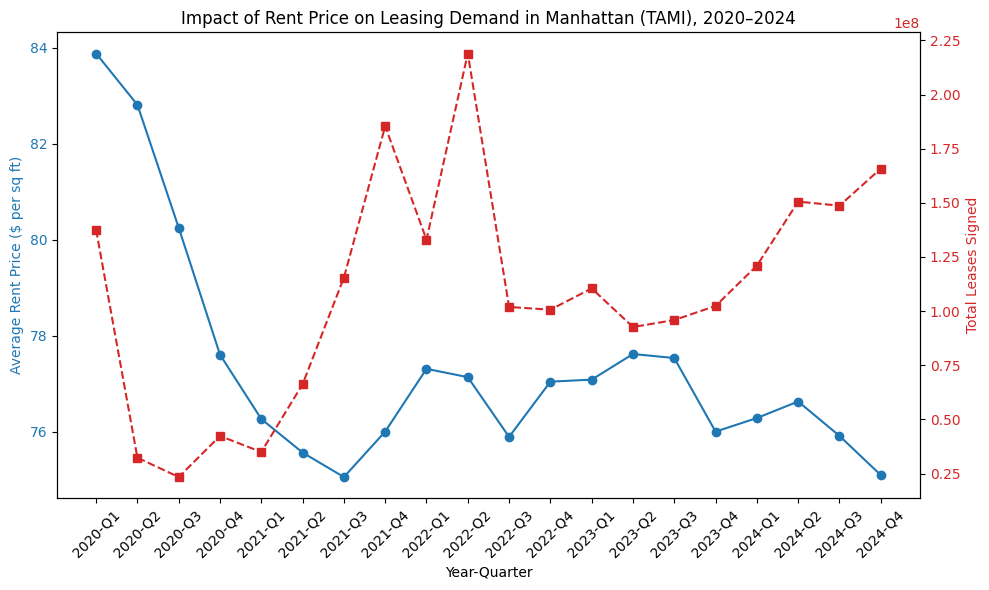

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
leases_data = pd.read_csv("/content/drive/Shareddrives/DataFest 2025/2. Data/Leases.csv")
market_occupancy_data = pd.read_csv("/content/drive/Shareddrives/DataFest 2025/2. Data/Major Market Occupancy Data.csv")

# 1) Filter to Manhattan, TAMI (Tech, Advertising, Media, Information), and years 2020–2024
manhattan_df = leases_data[
    (leases_data["market"] == "Manhattan")
    & (leases_data["internal_industry"].str.contains("Technology|Advertising|Media|Information", case=False, na=False))
    & (leases_data["year"].between(2020, 2024))
]

# 2) Create a combined label for year-quarter
#    If "quarter" column already has values like "Q1", "Q2", etc., we'll just concatenate
manhattan_df["year_quarter"] = manhattan_df["year"].astype(str) + "-" + manhattan_df["quarter"].astype(str)

# 3) Group by this new year_quarter label
manhattan_aggregated = manhattan_df.groupby("year_quarter").agg(
    avg_rent_price=("overall_rent", "mean"),
    total_leases=("leasing", "sum")
).reset_index()

# 4) Sort the data so the plot is in chronological order
#    This function parses e.g. "2021-Q3" -> (2021, 3)
def parse_year_q(value):
    # value should be something like "2021-Q3"
    year_str, q_str = value.split("-Q")
    return (int(year_str), int(q_str))

manhattan_aggregated["sort_key"] = manhattan_aggregated["year_quarter"].apply(parse_year_q)
manhattan_aggregated.sort_values("sort_key", inplace=True)
manhattan_aggregated.drop(columns="sort_key", inplace=True)

# 5) Create a dual-axis line plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left Y-axis: Average Rent
color = 'tab:blue'
ax1.set_xlabel("Year-Quarter")
ax1.set_ylabel("Average Rent Price ($ per sq ft)", color=color)
ax1.plot(
    manhattan_aggregated["year_quarter"],
    manhattan_aggregated["avg_rent_price"],
    color=color,
    marker='o',
    label="Avg Rent Price"
)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45)

# Right Y-axis: Total Leases
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Total Leases Signed", color=color)
ax2.plot(
    manhattan_aggregated["year_quarter"],
    manhattan_aggregated["total_leases"],
    color=color,
    marker='s',
    linestyle='--',
    label="Total Leases"
)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Impact of Rent Price on Leasing Demand in Manhattan (TAMI), 2020–2024")
fig.tight_layout()
plt.show()


In [18]:
'''
Leases.leases must be greater than 10,000
Leases.company_name not NA
Leases.market must occur in Major Market Occupancy.csv
'''

# Step 1: Ensure we have the list of major markets from the Major Market Occupancy dataset
major_markets = market_occupancy_data['market'].dropna().unique()

# Step 2: Filter leases_data based on the given conditions
filtered_leases = leases_data[
    (leases_data["leasedSF"] >= 10000) &  # Leases must be ≥ 10,000 sqft
    (leases_data["company_name"].notna()) &  # Company name must not be NA
    (leases_data["market"].isin(major_markets))  # Market must be in Major Market Occupancy dataset
]

# Display filtered dataset info
filtered_leases.info()

# Preview first few rows
filtered_leases.head()


<class 'pandas.core.frame.DataFrame'>
Index: 8879 entries, 135 to 194667
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   year                            8879 non-null   int64  
 1   quarter                         8879 non-null   object 
 2   monthsigned                     8550 non-null   float64
 3   market                          8879 non-null   object 
 4   building_name                   7458 non-null   object 
 5   building_id                     8879 non-null   object 
 6   address                         8879 non-null   object 
 7   region                          8879 non-null   object 
 8   city                            8879 non-null   object 
 9   state                           8879 non-null   object 
 10  zip                             8879 non-null   float64
 11  internal_submarket              8879 non-null   object 
 12  internal_class                  887

,year,quarter,monthsigned,market,building_name,building_id,address,region,city,state,...,overall_rent,direct_available_space,direct_availability_proportion,direct_internal_class_rent,direct_overall_rent,sublet_available_space,sublet_availability_proportion,sublet_internal_class_rent,sublet_overall_rent,leasing
135,2018,Q1,1.0,Austin,Lavaca Plaza,Austin_CBD_Austin_Lavaca Plaza_504 Lavaca St,504 Lavaca St,South,Austin,TX,...,36.596618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1738905.0
147,2018,Q1,1.0,Austin,River Place Building II,Austin_Northwest_Austin_River Place Building ...,6500 River Place Blvd,South,Austin,TX,...,36.596618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1738905.0
403,2018,Q1,1.0,Chicago,161 N Clark St,Chicago_Central Loop_Chicago_161 N Clark St_16...,161 N Clark St,Midwest/Central,Chicago,IL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
405,2018,Q1,1.0,Chicago,161 W Washington St,Chicago_Central Loop_Chicago_161 W Washington ...,30 N LaSalle St,Midwest/Central,Chicago,IL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
413,2018,Q1,1.0,Chicago,315 N Racine Ave,Chicago_Far West Loop/Fulton Market_Chicago_31...,315 N Racine Ave,Midwest/Central,Chicago,IL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **Treating Missing Values in Major Markets**

## Internal Industry

### TBD

In [19]:
major_markets

array(['Washington D.C.', 'Manhattan', 'Chicago', 'Houston',
       'Philadelphia', 'San Francisco', 'Los Angeles', 'Dallas/Ft Worth',
       'South Bay/San Jose', 'Austin'], dtype=object)

In [20]:
# Filter leases data set for major markets only
major_market_leases = leases_data[leases_data['market'].isin(major_markets)]

# Create TBD boolean mask
tbd_mask = major_market_leases['internal_industry'] == 'TBD'

In [21]:
major_market_tbd = major_market_leases[tbd_mask]
major_market_tbd['internal_industry']

,internal_industry
3203,TBD
5402,TBD
5404,TBD
5407,TBD
5408,TBD
...,...
194661,TBD
194663,TBD
194664,TBD
194665,TBD


In [22]:
# Check how many internal industry TBD appear in each major market
major_market_tbd.groupby('market').agg({'year': ['count']}).sort_values(by=('year', 'count'), ascending=False)


,year
,count
market,
Chicago,192
Manhattan,187
Houston,34
San Francisco,11
Dallas/Ft Worth,9
Austin,8
South Bay/San Jose,8
Philadelphia,3


### NA

In [23]:
NA_mask = major_market_leases['internal_industry'].isna()
NA_mask.value_counts()

,count
internal_industry,
True,77169
False,12231


In [24]:
# Check how many internal industry NA appear in each major market
major_market_NA = major_market_leases[NA_mask]
major_market_NA['internal_industry']

,internal_industry
100,NaN
101,NaN
102,NaN
103,NaN
104,NaN
...,...
194506,NaN
194507,NaN
194533,NaN
194644,NaN


In [25]:
major_market_NA.groupby('market').agg({'year': ['count']}).sort_values(by=('year', 'count'), ascending=False)

,year
,count
market,
Houston,15041
Los Angeles,14562
Dallas/Ft Worth,14413
Manhattan,12036
Austin,4595
Chicago,4050
Philadelphia,3632
San Francisco,3044


## Zip

In [26]:
manhattan_data = leases_data[leases_data['market']=='Manhattan']
manhattan_data[]

SyntaxError: invalid syntax (<ipython-input-26-c2bd5333c4b5>, line 2)

# **Industries in Major Markets**

In [27]:
industries_per_market = major_market_leases.groupby(
    ['market','internal_industry']).agg({'year':['count']}) # It could be any other column to count over

industries_per_market

year
                                                                   count
market          internal_industry                                       
Austin          Associations and Non-profit Organizations (exce...     4
                Business, Professional, and Consulting Services...    40
                Construction, Engineering and Architecture            22
                Coworking and Executive Suite Companies                7
                Education                                              2
...                                                                  ...
Washington D.C. Pharmaceuticals                                        6
                Real Estate (except coworking providers)              28
                Retail                                                13
                Technology, Advertising, Media, and Information      129
                Transportation                                        11

[190 rows x 1 columns]

In [28]:
industries_per_market.reset_index(inplace=True)
industries_per_market_sorted = industries_per_market.sort_values(by = ['market',('year','count')],ascending=[True,False])
industries_per_market_sorted

,market,internal_industry,year
,,,count
16,Austin,"Technology, Advertising, Media, and Information",136
6,Austin,Financial Services and Insurance,66
1,Austin,"Business, Professional, and Consulting Service...",40
9,Austin,Legal Services,38
2,Austin,"Construction, Engineering and Architecture",22
...,...,...,...
178,Washington D.C.,Energy & Utilities,12
189,Washington D.C.,Transportation,11
184,Washington D.C.,Personal Services and Recreation,7


In [29]:
industries_per_market_sorted.to_csv('industries_per_market_sorted.csv', index=False)

**Tech Industries**

---



# Dallas

### Visualizing Top Markets in Dallas

In [30]:
dallas_filter = industries_per_market_sorted['market'] == 'Dallas/Ft Worth'
dallas_market = industries_per_market_sorted[dallas_filter]
dallas_market.head(5)

,market,internal_industry,year
,,,count
44,Dallas/Ft Worth,Financial Services and Insurance,190
54,Dallas/Ft Worth,"Technology, Advertising, Media, and Information",103
39,Dallas/Ft Worth,"Business, Professional, and Consulting Service...",93
47,Dallas/Ft Worth,Legal Services,82
40,Dallas/Ft Worth,"Construction, Engineering and Architecture",78


In [31]:
dallas_market.reset_index(inplace=True, drop=True)

In [32]:
dallas_market.head(5)

,market,internal_industry,year
,,,count
0,Dallas/Ft Worth,Financial Services and Insurance,190
1,Dallas/Ft Worth,"Technology, Advertising, Media, and Information",103
2,Dallas/Ft Worth,"Business, Professional, and Consulting Service...",93
3,Dallas/Ft Worth,Legal Services,82
4,Dallas/Ft Worth,"Construction, Engineering and Architecture",78


### Filtering

In [ ]:
# Filter for transactions in Dallas
dallas_filt = leases_data['market'] == 'Dallas/Ft Worth'
dallas_leases = leases_data[dallas_filt]

In [ ]:
# Filter for transactions in tech
dallas_tech_filt =  dallas_leases['internal_industry'] == 'Technology, Advertising, Media, and Information'
dallas_tech = dallas_leases[dallas_tech_filt]

In [ ]:
# Filter for New or Relocate transactions
dallas_new_rel_filt = dallas_tech['transaction_type'].isin(['New','Relocation'])
dallas_new_rel = dallas_tech[dallas_new_rel_filt]

In [ ]:
dallas_new_rel['transaction_type'].value_counts()

,count
transaction_type,
New,62
Relocation,8


# Manhattan

# 2018-2024

### Visualizing Top Markets in Manhattan

In [33]:
man_filter = industries_per_market_sorted['market'] == 'Manhattan'
man_market = industries_per_market_sorted[man_filter]

In [34]:
man_market.reset_index(inplace=True, drop=True)

In [35]:
man_market.head(5)

,market,internal_industry,year
,,,count
0,Manhattan,Financial Services and Insurance,1400
1,Manhattan,"Technology, Advertising, Media, and Information",868
2,Manhattan,"Business, Professional, and Consulting Service...",425
3,Manhattan,Retail,401
4,Manhattan,Legal Services,393


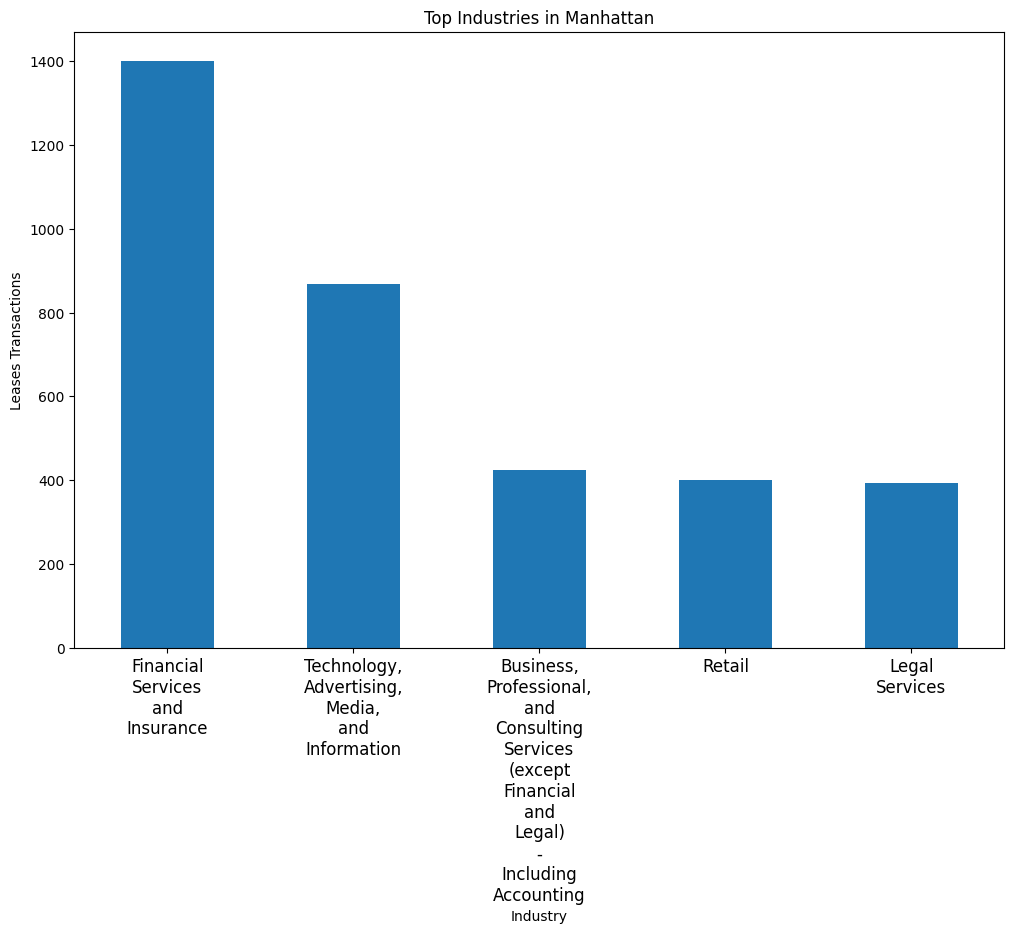

In [38]:
ax = man_market.head(5).plot(x='internal_industry', y=('year', 'count'), kind='bar', figsize=(12, 8), legend=False)
plt.xlabel('Industry')
plt.ylabel('Leases Transactions')
plt.xticks(
    ticks=range(len(man_market.head(5)['internal_industry'])),
    labels=[label.replace(' ', '\n') for label in man_market.head(5)['internal_industry']],
    fontsize=12,
    rotation=0
)
plt.title('Top Industries in Manhattan')
plt.show()


### Filtering

In [ ]:
# Filter for transactions in Manhattan
man_filt = leases_data['market'] == 'Manhattan'
man_leases = leases_data[man_filt]

In [ ]:
# Filter for transactions in tech
man_tech_filt =  man_leases['internal_industry'] == 'Technology, Advertising, Media, and Information'
man_tech = man_leases[man_tech_filt]

In [ ]:
# Filter for New or Relocate transactions
man_new_rel_filt = man_tech['transaction_type'].isin(['New','Relocation'])
man_new_rel = man_tech[man_new_rel_filt]

In [ ]:
man_new_rel['transaction_type'].value_counts()

,count
transaction_type,
Relocation,317
New,279


In [ ]:
trans_per_zip = man_new_rel.groupby('zip')['transaction_type'].value_counts()
trans_per_zip

zip      transaction_type
10001.0  Relocation          37
         New                 33
10002.0  New                  1
         Relocation           1
10003.0  New                 22
                             ..
10279.0  Relocation           1
10280.0  Relocation           4
10281.0  Relocation           3
10282.0  Relocation           4
10285.0  Relocation           1
Name: count, Length: 64, dtype: int64

In [ ]:
trans_per_zip_df = trans_per_zip.reset_index()

In [ ]:
trans_per_zip_sorted = trans_per_zip_df.sort_values(by = ['zip','transaction_type'],ascending=[True,False])
trans_per_zip_sorted

,zip,transaction_type,count
0,10001.0,Relocation,37
1,10001.0,New,33
3,10002.0,Relocation,1
2,10002.0,New,1
5,10003.0,Relocation,19
...,...,...,...
59,10279.0,Relocation,1
60,10280.0,Relocation,4
61,10281.0,Relocation,3
62,10282.0,Relocation,4


In [ ]:
pivot_df = trans_per_zip_df.pivot(index='zip', columns='transaction_type', values='count').fillna(0)
pivot_df['trans_tuple'] = list(zip(pivot_df['New'], pivot_df['Relocation']))
pivot_df

transaction_type,New,Relocation,trans_tuple
zip,,,
10001.0,33.0,37.0,"(33.0, 37.0)"
10002.0,1.0,1.0,"(1.0, 1.0)"
10003.0,22.0,19.0,"(22.0, 19.0)"
10004.0,8.0,6.0,"(8.0, 6.0)"
10005.0,9.0,15.0,"(9.0, 15.0)"
10006.0,6.0,9.0,"(6.0, 9.0)"
10007.0,14.0,27.0,"(14.0, 27.0)"
10010.0,20.0,32.0,"(20.0, 32.0)"
10011.0,12.0,18.0,"(12.0, 18.0)"


In [ ]:
pivot_df['trans_score'] = pivot_df['trans_tuple'].str[0] - pivot_df['trans_tuple'].str[1]

In [ ]:
pivot_df.sort_values(by='trans_score', ascending=False)

transaction_type,New,Relocation,trans_tuple,trans_score
zip,,,,
10017.0,31.0,17.0,"(31.0, 17.0)",14.0
10013.0,18.0,9.0,"(18.0, 9.0)",9.0
10018.0,23.0,18.0,"(23.0, 18.0)",5.0
10003.0,22.0,19.0,"(22.0, 19.0)",3.0
10004.0,8.0,6.0,"(8.0, 6.0)",2.0
10012.0,10.0,8.0,"(10.0, 8.0)",2.0
10019.0,9.0,7.0,"(9.0, 7.0)",2.0
10038.0,5.0,3.0,"(5.0, 3.0)",2.0
10036.0,16.0,15.0,"(16.0, 15.0)",1.0


# 2020-2022

In [ ]:
leases_data_20_to_22 = leases_data[leases_data['year'].isin([2020,2021,2022])]

In [ ]:
# Filter for transactions in Manhattan
man_filt = leases_data_20_to_22['market'] == 'Manhattan'
man_leases = leases_data_20_to_22[man_filt]

In [ ]:
# Filter for transactions in tech
man_tech_filt =  man_leases['internal_industry'] == 'Technology, Advertising, Media, and Information'
man_tech = man_leases[man_tech_filt]

In [ ]:
# Filter for New or Relocate transactions
man_new_rel_filt = man_tech['transaction_type'].isin(['New','Relocation'])
man_new_rel = man_tech[man_new_rel_filt]

In [ ]:
man_new_rel['transaction_type'].value_counts()

,count
transaction_type,
Relocation,131
New,124


In [ ]:
trans_per_zip = man_new_rel.groupby('zip')['transaction_type'].value_counts()
trans_per_zip

zip      transaction_type
10001.0  New                 16
         Relocation          13
10002.0  New                  1
         Relocation           1
10003.0  New                 12
         Relocation           6
10004.0  New                  2
         Relocation           1
10005.0  Relocation           6
         New                  3
10006.0  Relocation           4
         New                  2
10007.0  Relocation          16
         New                  5
10010.0  Relocation          13
         New                  7
10011.0  Relocation           9
         New                  5
10012.0  New                  4
         Relocation           3
10013.0  New                  8
         Relocation           2
10014.0  New                  4
         Relocation           3
10016.0  Relocation          14
         New                  5
10017.0  New                 17
         Relocation           7
10018.0  New                 13
         Relocation          10
10019.0  New                  4
         Relocation           2
10022.0  Relocation           2
         New                  1
10036.0  New                 10
         Relocation           5
10038.0  New                  2
         Relocation           1
10104.0  Relocation           2
10107.0  Relocation           1
10119.0  New                  1
         Relocation           1
10123.0  New                  1
         Relocation           1
10166.0  Relocation           1
10169.0  Relocation           2
         New                  1
10175.0  Relocation           1
10280.0  Relocation           1
10281.0  Relocation           1
10282.0  Relocation           2
Name: count, dtype: int64

In [ ]:
trans_per_zip_df = trans_per_zip.reset_index()

In [ ]:
trans_per_zip_sorted = trans_per_zip_df.sort_values(by = ['zip','transaction_type'],ascending=[True,False])
trans_per_zip_sorted

,zip,transaction_type,count
1,10001.0,Relocation,13
0,10001.0,New,16
3,10002.0,Relocation,1
2,10002.0,New,1
5,10003.0,Relocation,6
4,10003.0,New,12
7,10004.0,Relocation,1
6,10004.0,New,2
8,10005.0,Relocation,6
9,10005.0,New,3


In [ ]:
pivot_df = trans_per_zip_df.pivot(index='zip', columns='transaction_type', values='count').fillna(0)
pivot_df['trans_tuple'] = list(zip(pivot_df['New'], pivot_df['Relocation']))
pivot_df

transaction_type,New,Relocation,trans_tuple
zip,,,
10001.0,16.0,13.0,"(16.0, 13.0)"
10002.0,1.0,1.0,"(1.0, 1.0)"
10003.0,12.0,6.0,"(12.0, 6.0)"
10004.0,2.0,1.0,"(2.0, 1.0)"
10005.0,3.0,6.0,"(3.0, 6.0)"
10006.0,2.0,4.0,"(2.0, 4.0)"
10007.0,5.0,16.0,"(5.0, 16.0)"
10010.0,7.0,13.0,"(7.0, 13.0)"
10011.0,5.0,9.0,"(5.0, 9.0)"


In [ ]:
pivot_df['trans_score'] = pivot_df['trans_tuple'].str[0] - pivot_df['trans_tuple'].str[1]

In [ ]:
zip_scores_20_to_22 = pivot_df.sort_values(by='trans_score', ascending=False)
zip_scores_20_to_22

transaction_type,New,Relocation,trans_tuple,trans_score
zip,,,,
10017.0,17.0,7.0,"(17.0, 7.0)",10.0
10013.0,8.0,2.0,"(8.0, 2.0)",6.0
10003.0,12.0,6.0,"(12.0, 6.0)",6.0
10036.0,10.0,5.0,"(10.0, 5.0)",5.0
10001.0,16.0,13.0,"(16.0, 13.0)",3.0
10018.0,13.0,10.0,"(13.0, 10.0)",3.0
10019.0,4.0,2.0,"(4.0, 2.0)",2.0
10012.0,4.0,3.0,"(4.0, 3.0)",1.0
10038.0,2.0,1.0,"(2.0, 1.0)",1.0


# MAP: 2020 - 2022

# Debug 2020 - 2022

In [ ]:
# 1
# Split multi-ZIP rows into separate rows
expanded_zipcodes = expanded_zipcodes.assign(zcta=expanded_zipcodes["zcta"].str.split(", ")).explode("zcta")

# Reset index
expanded_zipcodes.reset_index(drop=True, inplace=True)

# Convert ZIP codes in transaction data to remove ".0"
zip_scores_20_to_22.index = zip_scores_20_to_22.index.astype(str).str.split('.').str[0]

# Convert ZIP codes in the shapefile to string
expanded_zipcodes["zcta"] = expanded_zipcodes["zcta"].astype(str).str.strip()

# Print to check format correction
print("Fixed Transaction ZIP codes:", zip_scores_20_to_22.index.unique()[:10])
print("Fixed Shapefile ZIP codes:", expanded_zipcodes["zcta"].unique()[:10])



Fixed Transaction ZIP codes: Index(['10017', '10013', '10003', '10036', '10001', '10018', '10019', '10012',
       '10038', '10014'],
      dtype='object', name='zip')
Fixed Shapefile ZIP codes: ['10001' '10119' '10199' '10002' '10003' '10026' '10004' '10005' '10271'
 '10006']


In [ ]:
# Merge again with corrected ZIPs
manhattan_zip_map_20_to_22 = expanded_zipcodes.merge(zip_scores_20_to_22, left_on="zcta", right_index=True)

# Check merge results
print("Total ZIPs in Merged Data (2020-2022):", len(manhattan_zip_map_20_to_22))
print(manhattan_zip_map_20_to_22.head())  # Check if ZIPs appear


Total ZIPs in Merged Data (2020-2022): 23
  modzcta         label   zcta  pop_est  \
0   10001  10001, 10118  10001  23072.0   
1   10001  10001, 10118  10119  23072.0   
3   10002         10002  10002  74993.0   
4   10003         10003  10003  54682.0   
6   10004         10004  10004   3028.0   

                                            geometry   New  Relocation  \
0  POLYGON ((-73.98774 40.74407, -73.98819 40.743...  16.0        13.0   
1  POLYGON ((-73.98774 40.74407, -73.98819 40.743...   1.0         1.0   
3  POLYGON ((-73.9975 40.71407, -73.99709 40.7146...   1.0         1.0   
4  POLYGON ((-73.98864 40.72293, -73.98876 40.722...  12.0         6.0   
6  MULTIPOLYGON (((-74.00827 40.70772, -74.00937 ...   2.0         1.0   

    trans_tuple  trans_score  
0  (16.0, 13.0)          3.0  
1    (1.0, 1.0)          0.0  
3    (1.0, 1.0)          0.0  
4   (12.0, 6.0)          6.0  
6    (2.0, 1.0)          1.0  


In [ ]:
# Find missing ZIPs after the merge
missing_zips_20_to_22 = set(expanded_zipcodes["zcta"]) - set(zip_scores_20_to_22.index)
print("ZIPs in shapefile but missing in transactions:", missing_zips_20_to_22)

missing_zips_transactions = set(zip_scores_20_to_22.index) - set(expanded_zipcodes["zcta"])
print("ZIPs in transactions but missing in shapefile:", missing_zips_transactions)


ZIPs in shapefile but missing in transactions: {'10173', '10452', '11430', '10168', '11420', '11001', '10458', '10475', '11004', '11225', '11354', '11427', '11356', '11003', '11428', '11217', '11237', '10037', '11201', '11422', '10304', '10027', '11209', '11219', '11691', '10039', '10451', '11385', '10465', '11239', '10031', '10154', '10303', '11223', '11692', '10152', '10115', '11106', '11228', '11005', '10069', '11231', '11368', '11233', '10033', '10029', '10456', '11235', '10310', '11040', '11362', '10162', '10457', '10466', '11425', '10306', '10021', '11218', '11224', '10026', '10103', '11229', '11424', '10128', '10035', '11236', '10112', '10271', '10470', '11101', '11103', '10454', '10462', '11414', '11213', '11210', '11373', '11429', '11357', '10460', '11419', '11378', '11415', '10464', '11434', '11379', '11222', '10474', '10023', '10467', '11433', '11104', '11364', '11371', '11367', '10153', '11365', '10278', '11212', '11694', '11238', '11360', '11416', '11417', '10307', '11216'

In [ ]:
print("Summary of trans_score column:")
print(manhattan_zip_map_20_to_22["trans_score"].describe())

# Check if all values are zero
if (manhattan_zip_map_20_to_22["trans_score"] == 0).all():
    print("⚠️ All trans_score values are zero. Map might not show anything.")


Summary of trans_score column:
count    23.000000
mean     -0.043478
std       4.752782
min     -11.000000
25%      -2.000000
50%       0.000000
75%       2.500000
max      10.000000
Name: trans_score, dtype: float64


In [ ]:
import folium

# Define Manhattan's center
manhattan_center = [40.7831, -73.9712]  # Central Park latitude & longitude

# Create a folium map centered on Manhattan
m_20_to_22 = folium.Map(location=manhattan_center, zoom_start=12)

# Add Choropleth Layer
folium.Choropleth(
    geo_data=manhattan_zip_map_20_to_22,  # Corrected dataset
    name="Choropleth",
    data=manhattan_zip_map_20_to_22,
    columns=["zcta", "trans_score"],
    key_on="feature.properties.zcta",
    fill_color="RdBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Net Firm Entry in Manhattan (2020-2022, New - Relocation)",
).add_to(m_20_to_22)

# Add ZIP Code Markers to the Map
for _, row in manhattan_zip_map_20_to_22.iterrows():
    folium.Marker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],  # Get ZIP centroid
        popup=f"ZIP: {row['zcta']}\nNet Firms: {row['trans_score']}",
        tooltip=row["zcta"],
        icon=folium.Icon(color="blue", icon="info-sign")  # Adjust color if needed
    ).add_to(m_20_to_22)

# Display the map
m_20_to_22


In [ ]:
print("Total ZIPs in 2020-2022 transactions:", len(zip_scores_20_to_22))
print("Sample ZIPs from transactions:\n", zip_scores_20_to_22.index[:10])


Total ZIPs in 2020-2022 transactions: 29
Sample ZIPs from transactions:
 Index(['10017', '10013', '10003', '10036', '10001', '10018', '10019', '10012',
       '10038', '10014'],
      dtype='object', name='zip')


In [ ]:
print("ZIPs in Shapefile Before Merge:", expanded_zipcodes["zcta"].unique()[:10])
print("ZIPs in Transaction Data Before Merge:", zip_scores_20_to_22.index.unique()[:10])


ZIPs in Shapefile Before Merge: ['10001' '10119' '10199' '10002' '10003' '10026' '10004' '10005' '10271'
 '10006']
ZIPs in Transaction Data Before Merge: Index(['10017.0', '10013.0', '10003.0', '10036.0', '10001.0', '10018.0',
       '10019.0', '10012.0', '10038.0', '10014.0'],
      dtype='object', name='zip')


In [ ]:
print("Total ZIPs in Merged Data (2020-2022):", len(manhattan_zip_map_20_to_22))


Total ZIPs in Merged Data (2020-2022): 0


In [ ]:
# Find missing ZIPs after the merge
missing_zips_20_to_22 = set(expanded_zipcodes["zcta"]) - set(zip_scores_20_to_22.index)
print("ZIPs in shapefile but missing in transactions:", missing_zips_20_to_22)

missing_zips_transactions = set(zip_scores_20_to_22.index) - set(expanded_zipcodes["zcta"])
print("ZIPs in transactions but missing in shapefile:", missing_zips_transactions)


ZIPs in shapefile but missing in transactions: {'10173', '10452', '11430', '10018', '10168', '11420', '11001', '10458', '10475', '11004', '11225', '11354', '11427', '10001', '11356', '11003', '11428', '11217', '11237', '10012', '10119', '10037', '10017', '10022', '11201', '11422', '10304', '10027', '11209', '11219', '11691', '10039', '10451', '11385', '10465', '10038', '11239', '10031', '10154', '10303', '11223', '11692', '10152', '10115', '11106', '11228', '11005', '10069', '10019', '11231', '11368', '11233', '10033', '10029', '10456', '11235', '10310', '11040', '11362', '10162', '10457', '10466', '11425', '10306', '10021', '11218', '11224', '10026', '10103', '10004', '11229', '11424', '10128', '10013', '10035', '10169', '11236', '10112', '10003', '10271', '10470', '11101', '11103', '10454', '10462', '10014', '11414', '11213', '11210', '11373', '10016', '11429', '11357', '10460', '11419', '11378', '11415', '10464', '11434', '10036', '10280', '10011', '11379', '11222', '10474', '10023'

# 2023-2024

In [ ]:
leases_data_23_to_24 = leases_data[leases_data['year'].isin([2023,2024])]

In [ ]:
# Filter for transactions in Manhattan
man_filt = leases_data_23_to_24['market'] == 'Manhattan'
man_leases = leases_data_23_to_24[man_filt]

In [ ]:
# Filter for transactions in tech
man_tech_filt =  man_leases['internal_industry'] == 'Technology, Advertising, Media, and Information'
man_tech = man_leases[man_tech_filt]

In [ ]:
# Filter for New or Relocate transactions
man_new_rel_filt = man_tech['transaction_type'].isin(['New','Relocation'])
man_new_rel = man_tech[man_new_rel_filt]

In [ ]:
man_new_rel['transaction_type'].value_counts()

,count
transaction_type,
Relocation,88
New,86


In [ ]:
trans_per_zip = man_new_rel.groupby('zip')['transaction_type'].value_counts()
trans_per_zip

zip      transaction_type
10001.0  Relocation          12
         New                  8
10003.0  Relocation           8
         New                  7
10004.0  New                  3
         Relocation           1
10005.0  New                  3
         Relocation           2
10006.0  New                  3
         Relocation           1
10007.0  New                  4
         Relocation           2
10010.0  New                 10
         Relocation          10
10011.0  New                  3
         Relocation           3
10012.0  Relocation           3
         New                  2
10013.0  New                  6
         Relocation           3
10014.0  Relocation           3
10016.0  New                 10
         Relocation          10
10017.0  New                  7
         Relocation           4
10018.0  Relocation           5
         New                  4
10019.0  New                  4
         Relocation           4
10020.0  Relocation           1
10022.0  Relocation           4
         New                  2
10036.0  Relocation           4
         New                  3
10038.0  New                  2
         Relocation           1
10080.0  New                  1
10111.0  New                  1
10112.0  New                  1
10118.0  Relocation           1
10119.0  Relocation           2
         New                  1
10122.0  New                  1
10176.0  Relocation           2
10280.0  Relocation           2
Name: count, dtype: int64

In [ ]:
trans_per_zip_df = trans_per_zip.reset_index()

In [ ]:
trans_per_zip_sorted = trans_per_zip_df.sort_values(by = ['zip','transaction_type'],ascending=[True,False])
trans_per_zip_sorted

,zip,transaction_type,count
0,10001.0,Relocation,12
1,10001.0,New,8
2,10003.0,Relocation,8
3,10003.0,New,7
5,10004.0,Relocation,1
4,10004.0,New,3
7,10005.0,Relocation,2
6,10005.0,New,3
9,10006.0,Relocation,1
8,10006.0,New,3


In [ ]:
pivot_df = trans_per_zip_df.pivot(index='zip', columns='transaction_type', values='count').fillna(0)
pivot_df['trans_tuple'] = list(zip(pivot_df['New'], pivot_df['Relocation']))
pivot_df

transaction_type,New,Relocation,trans_tuple
zip,,,
10001.0,8.0,12.0,"(8.0, 12.0)"
10003.0,7.0,8.0,"(7.0, 8.0)"
10004.0,3.0,1.0,"(3.0, 1.0)"
10005.0,3.0,2.0,"(3.0, 2.0)"
10006.0,3.0,1.0,"(3.0, 1.0)"
10007.0,4.0,2.0,"(4.0, 2.0)"
10010.0,10.0,10.0,"(10.0, 10.0)"
10011.0,3.0,3.0,"(3.0, 3.0)"
10012.0,2.0,3.0,"(2.0, 3.0)"


In [ ]:
pivot_df['trans_score'] = pivot_df['trans_tuple'].str[0] - pivot_df['trans_tuple'].str[1]

In [ ]:
zip_scores_2023_to_2024 = pivot_df.sort_values(by='trans_score', ascending=False)
zip_scores_2023_to_2024

transaction_type,New,Relocation,trans_tuple,trans_score
zip,,,,
10013.0,6.0,3.0,"(6.0, 3.0)",3.0
10017.0,7.0,4.0,"(7.0, 4.0)",3.0
10006.0,3.0,1.0,"(3.0, 1.0)",2.0
10007.0,4.0,2.0,"(4.0, 2.0)",2.0
10004.0,3.0,1.0,"(3.0, 1.0)",2.0
10112.0,1.0,0.0,"(1.0, 0.0)",1.0
10005.0,3.0,2.0,"(3.0, 2.0)",1.0
10080.0,1.0,0.0,"(1.0, 0.0)",1.0
10111.0,1.0,0.0,"(1.0, 0.0)",1.0


# MAP: 2023 - 2024


In [ ]:
# Convert ZIP codes in transaction data to remove ".0"
zip_scores_2023_to_2024.index = zip_scores_2023_to_2024.index.astype(str).str.split('.').str[0]

# Convert ZIP codes in the shapefile to string
expanded_zipcodes["zcta"] = expanded_zipcodes["zcta"].astype(str).str.strip()

# Print to check format correction
print("Fixed Transaction ZIP codes:", zip_scores_2023_to_2024.index.unique()[:10])
print("Fixed Shapefile ZIP codes:", expanded_zipcodes["zcta"].unique()[:10])


Fixed Transaction ZIP codes: Index(['10013', '10017', '10006', '10007', '10004', '10112', '10005', '10080',
       '10111', '10038'],
      dtype='object', name='zip')
Fixed Shapefile ZIP codes: ['10001' '10119' '10199' '10002' '10003' '10026' '10004' '10005' '10271'
 '10006']


In [ ]:
# Merge corrected ZIP shapefile with 2023-2024 transaction data
manhattan_zip_map_2023_to_2024 = expanded_zipcodes.merge(zip_scores_2023_to_2024, left_on="zcta", right_index=True)

# Check merge results
print("Total ZIPs in Merged Data (2023-2024):", len(manhattan_zip_map_2023_to_2024))
print(manhattan_zip_map_2023_to_2024.head())  # Check if ZIPs appear


Total ZIPs in Merged Data (2023-2024): 23
  modzcta         label   zcta  pop_est  \
0   10001  10001, 10118  10001  23072.0   
1   10001  10001, 10118  10119  23072.0   
4   10003         10003  10003  54682.0   
6   10004         10004  10004   3028.0   
7   10005         10005  10005   8831.0   

                                            geometry  New  Relocation  \
0  POLYGON ((-73.98774 40.74407, -73.98819 40.743...  8.0        12.0   
1  POLYGON ((-73.98774 40.74407, -73.98819 40.743...  1.0         2.0   
4  POLYGON ((-73.98864 40.72293, -73.98876 40.722...  7.0         8.0   
6  MULTIPOLYGON (((-74.00827 40.70772, -74.00937 ...  3.0         1.0   
7  POLYGON ((-74.00783 40.70309, -74.00786 40.703...  3.0         2.0   

   trans_tuple  trans_score  
0  (8.0, 12.0)         -4.0  
1   (1.0, 2.0)         -1.0  
4   (7.0, 8.0)         -1.0  
6   (3.0, 1.0)          2.0  
7   (3.0, 2.0)          1.0  


In [ ]:
# Find missing ZIPs after the merge
missing_zips_2023_to_2024 = set(expanded_zipcodes["zcta"]) - set(zip_scores_2023_to_2024.index)
print("ZIPs in shapefile but missing in transactions:", missing_zips_2023_to_2024)

missing_zips_transactions_2023_to_2024 = set(zip_scores_2023_to_2024.index) - set(expanded_zipcodes["zcta"])
print("ZIPs in transactions but missing in shapefile:", missing_zips_transactions_2023_to_2024)


ZIPs in shapefile but missing in transactions: {'10173', '10452', '11430', '10168', '11420', '11001', '10458', '10475', '11004', '11225', '11354', '11427', '11356', '11003', '11428', '11217', '11237', '10037', '11201', '11422', '10304', '10027', '11209', '11219', '11691', '10039', '10451', '11385', '10465', '11239', '10031', '10154', '10303', '11223', '11692', '10152', '10115', '11106', '11228', '11005', '10069', '11231', '11368', '11233', '10033', '10029', '10456', '11235', '10310', '11040', '11362', '10162', '10457', '10466', '11425', '10306', '10021', '11218', '11224', '10026', '10103', '11229', '11424', '10128', '10035', '10169', '11236', '10271', '10470', '11101', '11103', '10454', '10462', '11414', '11213', '11210', '11373', '11429', '11357', '10460', '11419', '11378', '11415', '10464', '11434', '11379', '11222', '10474', '10023', '10467', '11433', '11104', '11364', '11371', '11367', '10153', '11365', '10278', '11212', '11694', '11238', '11360', '11416', '11417', '10307', '11216'

In [ ]:
print("Summary of trans_score column (2023-2024):")
print(manhattan_zip_map_2023_to_2024["trans_score"].describe())

# Check if all values are zero
if (manhattan_zip_map_2023_to_2024["trans_score"] == 0).all():
    print("⚠️ All trans_score values are zero. Map might not show anything.")


Summary of trans_score column (2023-2024):
count    23.000000
mean     -0.043478
std       1.821045
min      -4.000000
25%      -1.000000
50%       0.000000
75%       1.000000
max       3.000000
Name: trans_score, dtype: float64


In [ ]:
import folium

# Define Manhattan's center
manhattan_center = [40.7831, -73.9712]  # Central Park latitude & longitude

# Create a folium map centered on Manhattan
m_2023_to_2024 = folium.Map(location=manhattan_center, zoom_start=12)

# Add Choropleth Layer with ZIP Tooltips
choropleth = folium.Choropleth(
    geo_data=manhattan_zip_map_2023_to_2024,  # Corrected dataset
    name="Choropleth",
    data=manhattan_zip_map_2023_to_2024,
    columns=["zcta", "trans_score"],
    key_on="feature.properties.zcta",
    fill_color="RdBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Net Firm Entry in Manhattan (2023-2024, New - Relocation)",
).add_to(m_2023_to_2024)

# Add ZIP Code Tooltips
tooltip = folium.GeoJsonTooltip(fields=["zcta"], aliases=["ZIP Code:"])
folium.GeoJson(manhattan_zip_map_2023_to_2024, tooltip=tooltip).add_to(m_2023_to_2024)

# Show map
m_2023_to_2024


In [ ]:
# Define Manhattan's center
manhattan_center = [40.7831, -73.9712]  # Central Park latitude & longitude

# Create a folium map centered on Manhattan
m_2023_to_2024 = folium.Map(location=manhattan_center, zoom_start=12)

# Add Choropleth Layer
folium.Choropleth(
    geo_data=manhattan_zip_map_2023_to_2024,  # Corrected dataset
    name="Choropleth",
    data=manhattan_zip_map_2023_to_2024,
    columns=["zcta", "trans_score"],
    key_on="feature.properties.zcta",
    fill_color="RdBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Net Firm Entry in Manhattan (2023-2024, New - Relocation)",
).add_to(m_2023_to_2024)

# Add ZIP Code Markers
for _, row in manhattan_zip_map_2023_to_2024.iterrows():
    folium.Marker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],  # Get ZIP centroid
        popup=f"ZIP: {row['zcta']}\nNet Firms: {row['trans_score']}",
        tooltip=row["zcta"],
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m_2023_to_2024)

# **Display Map Explicitly**
m_2023_to_2024  # Explicitly return in Jupyter Notebook


# Manhattan Map 2018-2024 (All)

In [ ]:
#### new FIx: KEEEP

import geopandas as gpd
import pandas as pd

# Load NYC ZIP Code Shapefile
zip_shapefile_path = "/content/geo_export_508388c7-7c11-4e0a-9b29-2f0ef88cd3a4.shp"  # Update with correct path
us_zipcodes = gpd.read_file(zip_shapefile_path)

# Convert ZIP column to string
us_zipcodes["zcta"] = us_zipcodes["zcta"].astype(str)

# Create a new dataframe where we split multi-ZIP rows into multiple rows
expanded_zipcodes = us_zipcodes.assign(zcta=us_zipcodes["zcta"].str.split(", ")).explode("zcta")

# Reset index and verify the split
expanded_zipcodes.reset_index(drop=True, inplace=True)

# Check fixed ZIP codes
print(expanded_zipcodes.head())
print("Total ZIPs after expansion:", len(expanded_zipcodes["zcta"].unique()))


  modzcta         label   zcta  pop_est  \
0   10001  10001, 10118  10001  23072.0   
1   10001  10001, 10118  10119  23072.0   
2   10001  10001, 10118  10199  23072.0   
3   10002         10002  10002  74993.0   
4   10003         10003  10003  54682.0   

                                            geometry  
0  POLYGON ((-73.98774 40.74407, -73.98819 40.743...  
1  POLYGON ((-73.98774 40.74407, -73.98819 40.743...  
2  POLYGON ((-73.98774 40.74407, -73.98819 40.743...  
3  POLYGON ((-73.9975 40.71407, -73.99709 40.7146...  
4  POLYGON ((-73.98864 40.72293, -73.98876 40.722...  
Total ZIPs after expansion: 215


In [ ]:
# Convert transaction ZIPs to string to ensure they match
pivot_df.index = pivot_df.index.astype(str)

# Merge with transaction data
manhattan_zip_map = expanded_zipcodes.merge(pivot_df, left_on="zcta", right_index=True)

# Check results
print(manhattan_zip_map.head())


Empty GeoDataFrame
Columns: [modzcta, label, zcta, pop_est, geometry, New, Relocation, trans_tuple, trans_score]
Index: []


In [ ]:
# Ensure 'manhattan_zip_map' contains only Manhattan ZIP codes
manhattan_geojson = manhattan_zip_map.to_json()

# Print to verify only Manhattan ZIPs remain
print("Manhattan ZIP codes in GeoJSON:", manhattan_zip_map["zcta"].unique())


# Define Manhattan's approximate center
manhattan_center = [40.7831, -73.9712]  # Central Park latitude & longitude

# Create a folium map centered on Manhattan
m = folium.Map(location=manhattan_center, zoom_start=12)

# Add Choropleth Layer using filtered Manhattan GeoJSON
folium.Choropleth(
    geo_data=manhattan_geojson,  # Use only Manhattan boundaries
    name="Choropleth",
    data=manhattan_zip_map,
    columns=["zcta", "trans_score"],
    key_on="feature.properties.zcta",
    fill_color="RdBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Net Firm Entry in Manhattan (New - Relocation)",
).add_to(m)

# Show map
m



Manhattan ZIP codes in GeoJSON: []


In [ ]:
# Add a boundary outline for Manhattan
folium.GeoJson(
    manhattan_geojson,
    name="Manhattan Boundary",
    style_function=lambda x: {"fillColor": "transparent", "color": "black", "weight": 2},
).add_to(m)


In [ ]:
# test 2

import geopandas as gpd

# Load NYC ZIP Code Shapefile
zip_shapefile_path = "/content/geo_export_508388c7-7c11-4e0a-9b29-2f0ef88cd3a4.shp"  # Update with correct path
us_zipcodes = gpd.read_file(zip_shapefile_path)

# Print column names to confirm ZIP column
print(us_zipcodes.columns)

# Print first few rows to check ZIP codes
print(us_zipcodes.head())


Index(['modzcta', 'label', 'zcta', 'pop_est', 'geometry'], dtype='object')
  modzcta         label                 zcta  pop_est  \
0   10001  10001, 10118  10001, 10119, 10199  23072.0   
1   10002         10002                10002  74993.0   
2   10003         10003                10003  54682.0   
3   10026         10026                10026  39363.0   
4   10004         10004                10004   3028.0   

                                            geometry  
0  POLYGON ((-73.98774 40.74407, -73.98819 40.743...  
1  POLYGON ((-73.9975 40.71407, -73.99709 40.7146...  
2  POLYGON ((-73.98864 40.72293, -73.98876 40.722...  
3  MULTIPOLYGON (((-73.96201 40.80551, -73.96007 ...  
4  MULTIPOLYGON (((-74.00827 40.70772, -74.00937 ...  


In [ ]:
# Ensure ZIP column is in string format
us_zipcodes["zcta"] = us_zipcodes["zcta"].astype(str)

# Filter for Manhattan ZIPs (Start with "100")
manhattan_zipcodes = us_zipcodes[us_zipcodes["zcta"].str.startswith("100")]

# Display Manhattan ZIP codes
print(manhattan_zipcodes["zcta"].unique())
print("Total Manhattan ZIP Codes:", len(manhattan_zipcodes["zcta"].unique()))


['10001, 10119, 10199' '10002' '10003' '10026' '10004' '10005, 10271'
 '10006' '10007, 10278, 10279' '10009' '10010' '10011' '10012' '10013'
 '10014' '10016'
 '10017, 10165, 10167, 10168, 10169, 10170, 10171, 10172, 10173, 10174, 10177'
 '10018' '10030' '10019, 10020, 10103, 10111, 10112' '10021'
 '10022, 10152, 10153, 10154' '10023' '10024' '10025' '10027, 10115'
 '10028' '10029' '10031' '10032' '10033' '10034' '10037' '10035'
 '10036, 10110' '10038' '10040' '10039' '10044' '10065' '10069'
 '10075, 10162']
Total Manhattan ZIP Codes: 41


In [ ]:
# Expand multi-ZIP rows into separate rows
expanded_zipcodes = manhattan_zipcodes.assign(zcta=manhattan_zipcodes["zcta"].str.split(", ")).explode("zcta")

# Reset index
expanded_zipcodes.reset_index(drop=True, inplace=True)

# Check if ZIP codes are now separate
print(expanded_zipcodes.head())
print("Total ZIPs after expansion:", len(expanded_zipcodes["zcta"].unique()))


  modzcta         label   zcta  pop_est  \
0   10001  10001, 10118  10001  23072.0   
1   10001  10001, 10118  10119  23072.0   
2   10001  10001, 10118  10199  23072.0   
3   10002         10002  10002  74993.0   
4   10003         10003  10003  54682.0   

                                            geometry  
0  POLYGON ((-73.98774 40.74407, -73.98819 40.743...  
1  POLYGON ((-73.98774 40.74407, -73.98819 40.743...  
2  POLYGON ((-73.98774 40.74407, -73.98819 40.743...  
3  POLYGON ((-73.9975 40.71407, -73.99709 40.7146...  
4  POLYGON ((-73.98864 40.72293, -73.98876 40.722...  
Total ZIPs after expansion: 66


In [ ]:
# Convert transaction ZIPs to string to ensure they match
pivot_df.index = pivot_df.index.astype(str)

# Merge corrected shapefile with transaction data
manhattan_zip_map = expanded_zipcodes.merge(pivot_df, left_on="zcta", right_index=True)

# Check results
print(manhattan_zip_map.head())
print("Total ZIPs after merge:", len(manhattan_zip_map["zcta"].unique()))


Empty GeoDataFrame
Columns: [modzcta, label, zcta, pop_est, geometry, New, Relocation, trans_tuple, trans_score]
Index: []
Total ZIPs after merge: 0


In [ ]:
import folium

# Define Manhattan's approximate center
manhattan_center = [40.7831, -73.9712]  # Central Park latitude & longitude

# Create a folium map centered on Manhattan
m = folium.Map(location=manhattan_center, zoom_start=12)

# Add Choropleth Layer using **filtered Manhattan shapefile**
folium.Choropleth(
    geo_data=manhattan_zip_map,  # Now correctly formatted
    name="Choropleth",
    data=manhattan_zip_map,
    columns=["zcta", "trans_score"],
    key_on="feature.properties.zcta",
    fill_color="RdBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Net Firm Entry in Manhattan (New - Relocation)",
).add_to(m)

# Show map
m


# MAP 2020 - 2022

In [ ]:
# Convert ZIP codes to string for consistent merging
zip_scores_20_to_22.index = zip_scores_20_to_22.index.astype(str)

# Merge the Manhattan ZIP shapefile with transaction scores
manhattan_zip_map_20_to_22 = expanded_zipcodes.merge(zip_scores_20_to_22, left_on="zcta", right_index=True)

# Check the merged data
print(manhattan_zip_map_20_to_22.head())
print("Total ZIPs after merge:", len(manhattan_zip_map_20_to_22["zcta"].unique()))


Empty GeoDataFrame
Columns: [modzcta, label, zcta, pop_est, geometry, New, Relocation, trans_tuple, trans_score]
Index: []
Total ZIPs after merge: 0


In [ ]:
import folium

# Define Manhattan's center for proper visualization
manhattan_center = [40.7831, -73.9712]  # Central Park latitude & longitude

# Create a folium map centered on Manhattan
m_20_to_22 = folium.Map(location=manhattan_center, zoom_start=12)

# Add Choropleth Layer for 2020-2022
folium.Choropleth(
    geo_data=manhattan_zip_map_20_to_22,  # Filtered Manhattan boundaries with 2020-2022 scores
    name="Choropleth",
    data=manhattan_zip_map_20_to_22,
    columns=["zcta", "trans_score"],
    key_on="feature.properties.zcta",
    fill_color="RdBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Net Firm Entry in Manhattan (2020-2022, New - Relocation)",
).add_to(m_20_to_22)

# Show map
m_20_to_22


In [ ]:
# Check for missing ZIPs
missing_zips_20_to_22 = set(expanded_zipcodes["zcta"]) - set(zip_scores_20_to_22.index)
print("ZIPs in shapefile but missing in 2020-2022 transactions:", missing_zips_20_to_22)


ZIPs in shapefile but missing in 2020-2022 transactions: {'10173', '10452', '11430', '10018', '10168', '11420', '11001', '10458', '10475', '11004', '11225', '11354', '11427', '10001', '11356', '11003', '11428', '11217', '11237', '10012', '10119', '10037', '10017', '10022', '11201', '11422', '10304', '10027', '11209', '11219', '11691', '10039', '10451', '11385', '10465', '10038', '11239', '10031', '10154', '10303', '11223', '11692', '10152', '10115', '11106', '11228', '11005', '10069', '10019', '11231', '11368', '11233', '10033', '10029', '10456', '11235', '10310', '11040', '11362', '10162', '10457', '10466', '11425', '10306', '10021', '11218', '11224', '10026', '10103', '10004', '11229', '11424', '10128', '10013', '10035', '10169', '11236', '10112', '10003', '10271', '10470', '11101', '11103', '10454', '10462', '10014', '11414', '11213', '11210', '11373', '10016', '11429', '11357', '10460', '11419', '11378', '11415', '10464', '11434', '10036', '10280', '10011', '11379', '11222', '10474